In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import TruncatedSVD

In [2]:
plt.style.use("ggplot")


In [3]:
amazon_ratings = pd.read_csv('../Datasets/ratings_Beauty.csv')
amazon_ratings

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200
...,...,...,...,...
2023065,A3DEHKPFANB8VA,B00LORWRJA,5.0,1405296000
2023066,A3DEHKPFANB8VA,B00LOS7MEE,5.0,1405296000
2023067,AG9TJLJUN5OM3,B00LP2YB8E,5.0,1405382400
2023068,AYBIB14QOI9PC,B00LPVG6V0,5.0,1405555200


In [4]:
amazon_ratings.nunique()

UserId       1210271
ProductId     249274
Rating             5
Timestamp       4231
dtype: int64

In [5]:
amazon_ratings.isnull().sum()

UserId       0
ProductId    0
Rating       0
Timestamp    0
dtype: int64

In [6]:
amazon_ratings.shape

(2023070, 4)

In [7]:
popular_products = pd.DataFrame(amazon_ratings.groupby('ProductId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(10)

,Rating
ProductId,
B001MA0QY2,7533
B0009V1YR8,2869
B0043OYFKU,2477
B0000YUXI0,2143
B003V265QW,2088
B000ZMBSPE,2041
B003BQ6QXK,1918
B004OHQR1Q,1885
B00121UVU0,1838


In [8]:
most_popular

,Rating
ProductId,
B001MA0QY2,7533
B0009V1YR8,2869
B0043OYFKU,2477
B0000YUXI0,2143
B003V265QW,2088
...,...
B004U81OBC,1
B004U7R0EI,1
B004U7Q2O2,1


In [9]:
mean_ratings = pd.DataFrame(amazon_ratings.groupby('ProductId')['Rating'].mean())
most_popular_mean = mean_ratings.sort_values('Rating', ascending=False)
most_popular_mean.loc['B001MA0QY2']

Rating    4.321386
Name: B001MA0QY2, dtype: float64

In [10]:
most_popular_mean

,Rating
ProductId,
0205616461,5.0
B00551HYQC,5.0
B0054ZSIXC,5.0
B00550UX52,5.0
B00550YQP0,5.0
...,...
B00586PNN0,1.0
B00585I1VW,1.0
B005854H5G,1.0


<Axes: xlabel='ProductId'>

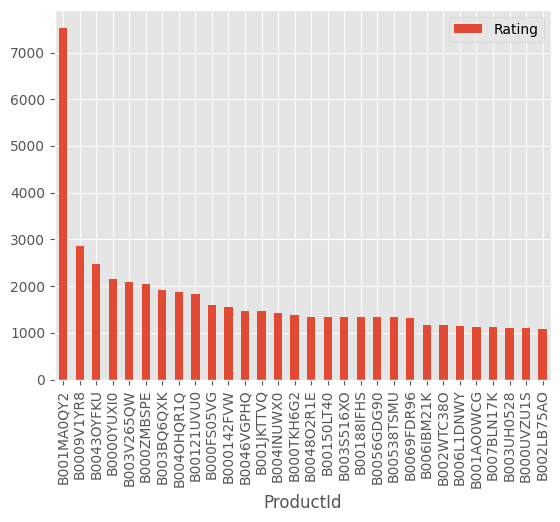

In [11]:
most_popular.head(30).plot(kind = "bar")

### A statistical approach to the recommender system

#### Building the utility matrix

In [12]:
# Subset of Amazon Ratings
amazon_ratings1 = amazon_ratings.head(10000)

In [13]:
amazon_ratings1

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200
...,...,...,...,...
9995,A9V4K2YJ2DWTQ,B000052YQ2,3.0,1396396800
9996,A3033CXHQ0NF8J,B000052YQ2,5.0,1291248000
9997,A1Z66KHEXSF3L5,B000052YQ2,3.0,1361577600
9998,A1Y7D2DRVBN59D,B000052YQ2,5.0,1402099200


In [14]:
amazon_ratings1.nunique()

UserId       9697
ProductId     886
Rating          5
Timestamp    2320
dtype: int64

There are 9697 users and 886 unique products in this dataframe amazon ratings 1 which is a miniature version of the original dataframe to simplify our mathematical calculations. With this we form the ratings utility matrix which consists of all possible user - item preferences as a matrix. The rows represent the users and the columns represent the products. 

In [15]:
ratings_utility_matrix = amazon_ratings1.pivot_table(values='Rating', index='UserId', columns='ProductId', fill_value=0)
ratings_utility_matrix.head()

ProductId,0205616461,0558925278,0733001998,0737104473,0762451459,1304139212,1304139220,130414089X,130414643X,1304146537,...,B000052YPE,B000052YPF,B000052YPG,B000052YPH,B000052YPM,B000052YPU,B000052YPV,B000052YPY,B000052YQ0,B000052YQ2
UserId,,,,,,,,,,,,,,,,,,,,,
A00205921JHJK5X9LNP42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A024581134CV80ZBLIZTZ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A03056581JJIOL5FSKJY7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A03099101ZRK4K607JVHH,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0505229A7NSH3FRXRR4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
ratings_utility_matrix.shape

(9697, 886)

Next we take the transpose of the matrix due to which we get a matrix with the products as rows and the columns as users  

In [17]:
X = ratings_utility_matrix.T
X.shape

(886, 9697)

This helps in reducing the dimensions of the matrix from 886 x 9697 to 886 x 10, to reduce the curse of dimensionality. 

In [18]:
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(886, 10)

In [19]:
decomposed_matrix

array([[ 1.20772713e-15,  4.61620701e-14,  1.07249357e-14, ...,
         4.46146976e-13,  2.72516503e-13,  5.05546772e-12],
       [-7.95418595e-15, -4.90893821e-13,  2.33288378e-13, ...,
        -4.99030209e-12, -1.36849819e-12, -2.81490479e-13],
       [-2.08227479e-17, -2.12820904e-15, -5.11751641e-16, ...,
         1.67336432e-14,  2.86472121e-14, -2.38164736e-13],
       ...,
       [ 3.63090436e-06,  2.27953992e-01, -1.04124059e-02, ...,
        -3.75032032e-03,  7.76848656e-05, -4.92605221e-02],
       [ 2.84243487e-07,  8.31276556e-04, -8.19026280e-05, ...,
         9.18788455e-04,  1.33724434e-03,  1.04578438e-03],
       [-4.03455725e-04,  4.10279392e-01,  3.49060547e-01, ...,
         2.87538689e-02, -1.53869038e-02,  4.34526761e-01]])

building the correlation matrix for the products to check the correlation between the various products involved

In [20]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(886, 886)

In [21]:
X.shape

(886, 9697)

In [22]:
X.index[99]

'6117036094'

In [23]:
i = "6117036094"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

99

In [24]:
amazon_ratings1[amazon_ratings1['ProductId'] == '6117036094']

,UserId,ProductId,Rating,Timestamp
294,ANLSZ40VRRB21,6117036094,5.0,1400457600


In [25]:
len(product_names)

886

In [26]:
correlation_product_id = correlation_matrix[product_ID]
correlation_product_id

array([-0.95910008, -0.02372532,  0.95204723,  0.79386821, -0.48033205,
        0.99552308,  0.91469832,  0.84438324,  0.99547181,  0.92149079,
        0.91469832,  0.92383337,  0.90905608,  0.99678734,  0.99552308,
        0.91469832,  0.91469832, -0.88750958,  0.90905622, -0.87822324,
        0.93559918,  0.49833247,  0.89561508,  0.92424801,  0.93475661,
       -0.37584333, -0.41152413,  0.98869233,  0.92424801, -0.32047738,
       -0.30078928,  0.99555014,  0.74633555, -0.3738302 ,  0.92397034,
        0.99552308, -0.3738302 , -0.91111436,  0.99542727,  0.98912116,
        0.98910521, -0.37584333,  0.99555228,  0.99552308,  0.99552308,
        0.99552308,  0.92424801,  0.99552308,  0.99548255,  0.98912116,
       -0.85095769, -0.98129316, -0.94926206, -0.88186508,  0.31190076,
       -0.99177128, -0.93999744,  0.88312405, -0.95937453, -0.94944672,
        0.86626158, -0.62064819,  0.94085491,  0.89208717,  0.96494802,
       -0.69245785, -0.59696476, -0.74704089,  0.98137096, -0.97

So if we assume that the customer has bought the product 6117036094 then we recommend 10 items to the customer closely correlated to the item the customer has bought before.

In [27]:
Recommend = list(X.index[correlation_product_id > 0.90])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:9]

['0733001998',
 '1304139212',
 '1304139220',
 '130414643X',
 '1304146537',
 '130414674X',
 '1304168522',
 '1304174778',
 '1304174867']

### A deep learning approach to the recommender system
